# NECESSITE L'INSTALLATION SUIVANTE

pip install git+https://github.com/fra31/auto-attack

# Import

In [1]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets,models
from torchvision.transforms import ToTensor, Lambda
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
import copy
import numpy as np
import os
import autoPGD
import pandas as pd
from autoattack import AutoAttack

# Dataset et modèle

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
## Extracted from https://github.com/SSAA3/stochastic-sparse-adv-attacks/blob/378f9ad8e6e3880482e7b15a2cdd5a60faffdfe4/data/train/ResNet18.py
#>>>>>>>>>>>>>>>>>>>

## Extracted from https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py

'''
ResNet in PyTorch.
For Pre-activation ResNet, see 'preact_resnet.py'.
Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
 Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''
# Imports déjà effectués dans la section #**Imports**

# import torch
# import torch.nn as nn
# import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [4]:
load_path = torch.load('ResNet18_CIFAR10.pt', map_location=torch.device(device))
net = ResNet18()
net = torch.nn.DataParallel(net)
net.load_state_dict(load_path, strict=False)
net = net.eval()

In [24]:
norm=transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010))

def load_CIRFA10(batch_size):

  PATH = "./data"
  resize = centercrop = 32
  transform_test = transforms.Compose([
            transforms.Resize(resize),
            transforms.CenterCrop(centercrop),
            transforms.ToTensor()])

  testset = torchvision.datasets.CIFAR10(root=PATH, train=False,
                                           download=False, transform=transform_test)
  testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, pin_memory=True,
                                             shuffle=False)

  classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
  return testloader, classes

In [25]:
norm=transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010))

In [26]:
batch_size=100

In [27]:
testloader, classes = load_CIRFA10(batch_size)

In [28]:
def new_testloader(model):
    l=[]
    n=0
    for _,(datas, labels) in enumerate(testloader):
        datas, labels=datas.to(device), labels.to(device)
        list_tf=(model(norm(datas)).max(dim=1)[1] == labels)
        n=n+list_tf.sum().item()
        l.append((datas[list_tf], labels[list_tf]))
    return n,l

In [29]:
n_testloader2,testloader2=new_testloader(net)
print(n_testloader2)

9555


# Paramètres

In [18]:
num_iter = 25
num_restart = 1
l_algo=["APGD"]
l_eps=[2/255,4/255,8/255,16/255] 

# Résultats AutoPGD chargé depuis le fichier CSV avec 25 itérations et 1 seul restart

In [101]:
def path(type,algo,eps):
  PATH = './csvfiles'
  return PATH+algo+'/'+algo+'_'+f'{eps}'+'_'+type+'_9555'+'.csv'

def evaluation(algo,eps,nb):
  labels=pd.read_csv(path("labels",algo,eps))
  return (labels["Labels data"][:nb]==labels["Labels data_attack"][:nb]).sum()/nb

def comparatif(n):
  form1 = "{0:<30}{1:<15}{2:<15}{3:<30}"
  form2 = "{0:<30}{1:<15}{2:<15.4f}{3:<30}"
  print(form1.format("Attack","epsilon","Accuracy","Sample test"))
  for algo in l_algo:
    print("")
    for eps in l_eps:
      print(form2.format(algo,f"{int(eps*255)}/255",evaluation(algo,int(eps*255),n),n))
  return

In [102]:
comparatif(1000)

Attack                        epsilon        Accuracy       Sample test                   

APGD                          2/255          0.0200         1000                          
APGD                          4/255          0.0010         1000                          
APGD                          8/255          0.0000         1000                          
APGD                          16/255         0.0000         1000                          


# Attaque

### Objet Auto pgd (est import dant autoPGD)

In [14]:
class APGDAttack():
    """
    AutoPGD
    https://arxiv.org/abs/2003.01690

    :param predict:       forward pass function
    :param norm:          Lp-norm of the attack ('Linf', 'L2', 'L0' supported)
    :param n_restarts:    number of random restarts
    :param n_iter:        number of iterations
    :param eps:           bound on the norm of perturbations
    :param seed:          random seed for the starting point
    :param loss:          loss to optimize ('ce', 'dlr' supported)
    :param eot_iter:      iterations for Expectation over Trasformation
    :param rho:           parameter for decreasing the step size
    """

    def __init__(
            self,
            predict,
            n_iter=100,
            norm='Linf',
            n_restarts=1,
            eps=None,
            seed=0,
            loss='ce',
            eot_iter=1,
            rho=.75,
            topk=None,
            verbose=False,
            device=None,
            use_largereps=False,
            is_tf_model=False,
            logger=None):
        """
        AutoPGD implementation in PyTorch
        """
        
        self.model = predict
        self.n_iter = n_iter
        self.eps = eps
        self.norm = norm
        self.n_restarts = n_restarts
        self.seed = seed
        self.loss = loss
        self.eot_iter = eot_iter
        self.thr_decr = rho
        self.topk = topk
        self.verbose = verbose
        self.device = device
        self.use_rs = True
        #self.init_point = None
        self.use_largereps = use_largereps
        #self.larger_epss = None
        #self.iters = None
        self.n_iter_orig = n_iter + 0
        self.eps_orig = eps + 0.
        self.is_tf_model = is_tf_model
        self.y_target = None
        self.logger = logger

### Perturbation

In [12]:
 def perturb(self, x, y=None, x_init=None):
        """
        :param x:           clean images
        :param y:           clean labels, if None we use the predicted labels
        """

        assert self.loss in ['dlr-targeted'] #'ce-targeted'
        if not y is None and len(y.shape) == 0:
            x.unsqueeze_(0)
            y.unsqueeze_(0)
        self.init_hyperparam(x)

        x = x.detach().clone().float().to(self.device)
        if not self.is_tf_model:
            y_pred = self.model(x).max(1)[1]
        else:
            y_pred = self.model.predict(x).max(1)[1]
        if y is None:
            #y_pred = self._get_predicted_label(x)
            y = y_pred.detach().clone().long().to(self.device)
        else:
            y = y.detach().clone().long().to(self.device)

        adv = x.clone()
        acc = y_pred == y
        if self.verbose:
            print('-------------------------- ',
                'running {}-attack with epsilon {:.5f}'.format(
                self.norm, self.eps),
                '--------------------------')
            print('initial accuracy: {:.2%}'.format(acc.float().mean()))

        startt = time.time()

        torch.random.manual_seed(self.seed)
        torch.cuda.random.manual_seed(self.seed)

        #
        
        if self.use_largereps:
            epss = [3. * self.eps_orig, 2. * self.eps_orig, 1. * self.eps_orig]
            iters = [.3 * self.n_iter_orig, .3 * self.n_iter_orig,
                .4 * self.n_iter_orig]
            iters = [math.ceil(c) for c in iters]
            iters[-1] = self.n_iter_orig - sum(iters[:-1])
            if self.verbose:
                print('using schedule [{}x{}]'.format('+'.join([str(c
                    ) for c in epss]), '+'.join([str(c) for c in iters])))
        
        for target_class in range(2, self.n_target_classes + 2):
            for counter in range(self.n_restarts):
                ind_to_fool = acc.nonzero().squeeze()
                if len(ind_to_fool.shape) == 0:
                    ind_to_fool = ind_to_fool.unsqueeze(0)
                if ind_to_fool.numel() != 0:
                    x_to_fool = x[ind_to_fool].clone()
                    y_to_fool = y[ind_to_fool].clone()
                    
                    if not self.is_tf_model:
                        output = self.model(x_to_fool)
                    else:
                        output = self.model.predict(x_to_fool)
                    self.y_target = output.sort(dim=1)[1][:, -target_class]

                    if not self.use_largereps:
                        res_curr = self.attack_single_run(x_to_fool, y_to_fool)
                    else:
                        res_curr = self.decr_eps_pgd(x_to_fool, y_to_fool, epss, iters)
                    best_curr, acc_curr, loss_curr, adv_curr = res_curr
                    ind_curr = (acc_curr == 0).nonzero().squeeze()

                    acc[ind_to_fool[ind_curr]] = 0
                    adv[ind_to_fool[ind_curr]] = adv_curr[ind_curr].clone()
                    if self.verbose:
                        print('target class {}'.format(target_class),
                            '- restart {} - robust accuracy: {:.2%}'.format(
                            counter, acc.float().mean()),
                            '- cum. time: {:.1f} s'.format(
                            time.time() - startt))

        return adv

# Generation CSV

In [32]:
def generation_APGD(model, epsi,n):
    PATH ='./csvfilesAPGD'
    df_attacks=pd.DataFrame()
    df_labels=pd.DataFrame()
    print('{0:<22} {1:<}'.format("Start",f"{epsi}"))
    n_handled=0
    adv = AutoAttack(model, norm='Linf', eps=epsi, version='standard')
    for i,(datas, labels) in enumerate(testloader2):
        if i+1>n:
            break
        datas, labels=datas.to(device), labels.to(device)
        tabX = [datas]
        x_test = torch.cat(tabX, 0)
        #x_attack = adv.perturb(x=x_test)
        adv.apgd.loss = 'ce'
        adv.apgd.seed = adv.get_seed()
        x_attack = adv.apgd.perturb(x=x_test,y=labels)
        n_handled=n_handled+x_attack.shape[0]

        batch_in = pd.DataFrame(x_attack.view(datas.size()[0], -1).cpu().detach().numpy())
        df_attacks = df_attacks.append(batch_in)
        
        Labels =  pd.DataFrame({'Labels data' : labels.cpu().type(torch.int64).detach().numpy(), 
                          'Labels data_attack': (model((x_attack)).max(dim=1)[1]).cpu().type(torch.int64).detach().numpy()})
        df_labels = df_labels.append(Labels)
        print('{0:<6} {1:<15}'.format(f"{n_handled}" ,"ème traité"))

    df_attacks.to_csv(os.path.join(PATH, f'APGD_{int(epsi*255)}_datas_attack_{n_handled}.csv'), index=False)
    df_labels.to_csv(os.path.join(PATH, f'APGD_{int(epsi*255)}_labels_{n_handled}.csv'), index=False)

    return ("End")

def generation_APGD_eps(model, l_eps, n,nbim):
    for eps in l_eps:
        generation_APGD(model,eps,n,nbim)
    return

In [33]:
generation_APGD(net, 2/255,np.infty)

Start                  0.00784313725490196
setting parameters for standard version
96     ème traité     
190    ème traité     
287    ème traité     
381    ème traité     
476    ème traité     
573    ème traité     
669    ème traité     
761    ème traité     
857    ème traité     
954    ème traité     
1049   ème traité     
1143   ème traité     
1241   ème traité     
1335   ème traité     
1431   ème traité     
1529   ème traité     
1624   ème traité     
1718   ème traité     
1814   ème traité     
1910   ème traité     
2006   ème traité     
2099   ème traité     
2192   ème traité     
2290   ème traité     
2385   ème traité     
2479   ème traité     
2576   ème traité     
2672   ème traité     
2767   ème traité     
2864   ème traité     
2961   ème traité     
3055   ème traité     
3150   ème traité     
3243   ème traité     
3339   ème traité     
3436   ème traité     
3530   ème traité     
3623   ème traité     
3720   ème traité     
3815   ème traité   

'End'

In [38]:
generation_APGD(net, 4/255,np.infty)

Start                  0.01568627450980392
setting parameters for standard version
96     ème traité     
190    ème traité     
287    ème traité     
381    ème traité     
476    ème traité     
573    ème traité     
669    ème traité     
761    ème traité     
857    ème traité     
954    ème traité     
1049   ème traité     
1143   ème traité     
1241   ème traité     
1335   ème traité     
1431   ème traité     
1529   ème traité     
1624   ème traité     
1718   ème traité     
1814   ème traité     
1910   ème traité     
2006   ème traité     
2099   ème traité     
2192   ème traité     
2290   ème traité     
2385   ème traité     
2479   ème traité     
2576   ème traité     
2672   ème traité     
2767   ème traité     
2864   ème traité     
2961   ème traité     
3055   ème traité     
3150   ème traité     
3243   ème traité     
3339   ème traité     
3436   ème traité     
3530   ème traité     
3623   ème traité     
3720   ème traité     
3815   ème traité   

'End'

In [44]:
generation_APGD(net, 8/255,np.infty)

Start                  0.03137254901960784
setting parameters for standard version
96     ème traité     
190    ème traité     
287    ème traité     
381    ème traité     
476    ème traité     
573    ème traité     
669    ème traité     
761    ème traité     
857    ème traité     
954    ème traité     
1049   ème traité     
1143   ème traité     
1241   ème traité     
1335   ème traité     
1431   ème traité     
1529   ème traité     
1624   ème traité     
1718   ème traité     
1814   ème traité     
1910   ème traité     
2006   ème traité     
2099   ème traité     
2192   ème traité     
2290   ème traité     
2385   ème traité     
2479   ème traité     
2576   ème traité     
2672   ème traité     
2767   ème traité     
2864   ème traité     
2961   ème traité     
3055   ème traité     
3150   ème traité     
3243   ème traité     
3339   ème traité     
3436   ème traité     
3530   ème traité     
3623   ème traité     
3720   ème traité     
3815   ème traité   

'End'

In [48]:
generation_APGD(net, 16/255,np.infty)

Start                  0.06274509803921569
setting parameters for standard version
96     ème traité     
190    ème traité     
287    ème traité     
381    ème traité     
476    ème traité     
573    ème traité     
669    ème traité     
761    ème traité     
857    ème traité     
954    ème traité     
1049   ème traité     
1143   ème traité     
1241   ème traité     
1335   ème traité     
1431   ème traité     
1529   ème traité     
1624   ème traité     
1718   ème traité     
1814   ème traité     
1910   ème traité     
2006   ème traité     
2099   ème traité     
2192   ème traité     
2290   ème traité     
2385   ème traité     
2479   ème traité     
2576   ème traité     
2672   ème traité     
2767   ème traité     
2864   ème traité     
2961   ème traité     
3055   ème traité     
3150   ème traité     
3243   ème traité     
3339   ème traité     
3436   ème traité     
3530   ème traité     
3623   ème traité     
3720   ème traité     
3815   ème traité   

'End'

# Performance du réseau de neurones

In [58]:
 def performance(batch_size, model,testloader):
    n_attack = 0
    n_handled=0
    print('{0:<22} {1:<}'.format("Image handeled","Accuracy of the neural network"))
    for i,(datas, labels) in enumerate(testloader):
        datas, labels=datas.to(device), labels.to(device)
        n_attack = n_attack + \
            (model(norm(datas)).max(dim=1)[1] != labels).sum().item()
        n_handled=n_handled+datas.shape[0]
        if i==0:
            print('{:^45}'.format("Start !"))
        if (n_handled % 100 == 0) and n_handled > 0:
            print('{0:<6} {1:<15} {2:<10}'.format(f"{(i+1)*batch_size}" ,"ème traité",f"{100*(1-n_attack/((i+1)*batch_size))}"))
    return 1-n_attack/n_testloader2

In [59]:
performance(batch_size,net,testloader)

Image handeled         Accuracy of the neural network
                   Start !                   
100    ème traité      96.0      
200    ème traité      95.0      
300    ème traité      95.66666666666667
400    ème traité      95.25     
500    ème traité      95.19999999999999
600    ème traité      95.5      
700    ème traité      95.57142857142857
800    ème traité      95.125    
900    ème traité      95.22222222222221
1000   ème traité      95.39999999999999
1100   ème traité      95.36363636363636
1200   ème traité      95.25     
1300   ème traité      95.46153846153847
1400   ème traité      95.35714285714285
1500   ème traité      95.39999999999999
1600   ème traité      95.5625   
1700   ème traité      95.52941176470588
1800   ème traité      95.44444444444444
1900   ème traité      95.47368421052632
2000   ème traité      95.5      
2100   ème traité      95.52380952380952
2200   ème traité      95.4090909090909
2300   ème traité      95.30434782608695
2400   ème tra

0.9534275248560963

# Performance de l'Attaque APGD

In [91]:
def performance_APGD(model, epsi):
    n_attack = 0
    n_handled=0
    
    adv = AutoAttack(model, norm='Linf', eps=epsi, version='standard')
    print('{0:<22} {1:<}'.format("Image handeled","Accuracy of the neural network"))
    for i,(datas, labels) in enumerate(testloader2[:100]):
        datas, labels=datas.to(device), labels.to(device)
        tabX = [datas]
        x_test = torch.cat(tabX, 0)
        adv.apgd.loss = 'ce'
        adv.apgd.seed = adv.get_seed()
        x_attack = adv.apgd.perturb(x=x_test,y=labels)
        n_attack = n_attack + \
            (model((x_attack)).max(dim=1)[1] != labels).sum().item()
        n_handled=n_handled+datas.shape[0]
        if i==0:
            print('{:^45}'.format("Start !"))
        if (n_handled % 100 == 0) and n_handled>0:
            print('{0:<6} {1:<15} {2:<10}'.format(f"{n_handled}" ,"ème traité",f"{100*(1-n_attack/n_handled)}"))
    return 1-n_attack/n_testloader2

def performance_APGD_eps(model, l_eps):
    l=[]
    print("Accuracy")
    for epsi in l_eps:
        n_attack = 0
        adv = AutoAttack(model, norm='Linf', eps=epsi, version='standard')
        for _,(datas, labels) in enumerate(testloader2):
            datas, labels=datas.to(device), labels.to(device)
            tabX = [datas]
            x_test = torch.cat(tabX, 0)
            adv.apgd.loss = 'ce'
            adv.apgd.seed = adv.get_seed()
            x_attack = adv.apgd.perturb(x=x_test,y=labels)
            n_attack = n_attack + \
                (model((x_attack)).max(dim=1)[1] != labels).sum().item()
        l.append((epsi,1-n_attack/n_testloader2))
        print(f"{l[-1]} - ok !")
    return l

### Performance de l'adversaire

In [64]:
performance_APGD(net,2/255)

setting parameters for standard version
Image handeled         Accuracy of the neural network
                   Start !                   


0.018942961800104685

In [ ]:
performance_APGD_eps(net,l_eps)

# Visualisation

In [99]:
def visualisation_APGD_num_iter(model, data, label, l_epsilon, l_num_iter):
    for epsilon in l_epsilon :
        l_data_attack = []
        for num_iter in l_num_iter:
            adv = AutoAttack(model, norm='Linf', eps=epsilon, version='standard')
            tabX = [data]
            x_test = torch.cat(tabX, 0)
            tabX = [data]
            x_test = torch.cat(tabX, 0)
            adv.apgd.loss = 'ce'
            adv.apgd.seed = adv.get_seed()
            adv.apgd.n_iter = num_iter
            data_attack = adv.apgd.perturb(x=x_test,y=label)
            l_data_attack.append(F.nll_loss(
              model((data_attack)), label).item())

        plt.plot(l_num_iter, l_data_attack)
    plt.xlabel("Itérations")
    plt.ylabel("Null loss")
    plt.legend([str(int(i*255))+"/255" for i in l_epsilon],title="ε")
    plt.title(f"{batch_size} images")
    plt.savefig("image.png")
    return plt.show()

setting parameters for standard version
setting parameters for standard version
setting parameters for standard version
setting parameters for standard version
setting parameters for standard version
setting parameters for standard version
setting parameters for standard version
setting parameters for standard version
setting parameters for standard version
setting parameters for standard version
setting parameters for standard version
setting parameters for standard version
setting parameters for standard version
setting parameters for standard version
setting parameters for standard version
setting parameters for standard version
setting parameters for standard version
setting parameters for standard version
setting parameters for standard version
setting parameters for standard version


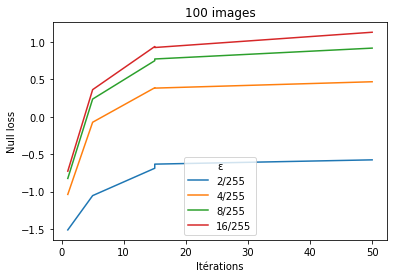

In [100]:
data,label=testloader2[1]
data,label=data.to(device),label.to(device)
visualisation_APGD_num_iter(net, data, label, l_eps, [1,5,15,15,50])

# Comparaison programme GitHub

In [ ]:
from autoattack import AutoAttack
for epsi in l_eps:
    adversary = AutoAttack(net, eps=epsi,version='standard')

    l = [x for (x, y) in testloader]
    x_test = torch.cat(l, 0)
    l = [y for (x, y) in testloader]
    y_test = torch.cat(l, 0)
    adversary.attacks_to_run = ['apgd-ce']
    adversary.apgd.n_restarts = 2
    with torch.no_grad():
        adv_complete = adversary.run_standard_evaluation_individual(x_test[:100],y_test[:100], bs=batch_size)

setting parameters for standard version
using standard version including apgd-ce
robust accuracy by APGD-CE 	 3.00% 	 (time attack: 20.6 s)
setting parameters for standard version
using standard version including apgd-ce
robust accuracy by APGD-CE 	 1.00% 	 (time attack: 20.1 s)
setting parameters for standard version
using standard version including apgd-ce
robust accuracy by APGD-CE 	 0.00% 	 (time attack: 18.4 s)
setting parameters for standard version
using standard version including apgd-ce
robust accuracy by APGD-CE 	 0.00% 	 (time attack: 18.5 s)
